In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [15]:
import json
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [3]:
from ssl_neuron.datasets import GraphDataset
from ssl_neuron.utils import (
    plot_neuron,
    plot_tsne,
    neighbors_to_adjacency_torch,
    compute_eig_lapl_torch_batch,
)
from ssl_neuron.graphdino import create_model

#### Load config

In [4]:
config = json.load(open("../configs/config.json"))

#### Load model + checkpoint

In [5]:
model = create_model(config)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load("../ckpts/final_ckpt.pt", map_location=device)

In [7]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
# model.eval()
# # model.cuda();

#### Load dataset

In [9]:
config

{'model': {'num_classes': 1000,
  'dim': 32,
  'depth': 7,
  'n_head': 8,
  'pos_dim': 32,
  'move_avg': 0.999,
  'center_avg': 0.9,
  'teacher_temp': 0.06},
 'data': {'class': 'allen',
  'path': './../data/',
  'n_nodes': 200,
  'feat_dim': 3,
  'batch_size': 64,
  'num_workers': 6,
  'jitter_var': 1,
  'translate_var': 10,
  'rotation_axis': 'y',
  'n_drop_branch': 10},
 'optimizer': {'lr': 0.0001, 'max_iter': 100000, 'exp_decay': 0.5},
 'trainer': {'ckpt_dir': 'ssl_neuron/ckpts/',
  'save_ckpt_every': 50,
  'seed': None}}

In [10]:
dset = GraphDataset(config, mode="all")

100%|██████████| 430/430 [00:03<00:00, 108.15it/s]


In [11]:
feat, neigh = dset.__getsingleitem__(0)

In [12]:
feat.shape, len(neigh)

((1000, 3), 1000)

#### Plot neuron

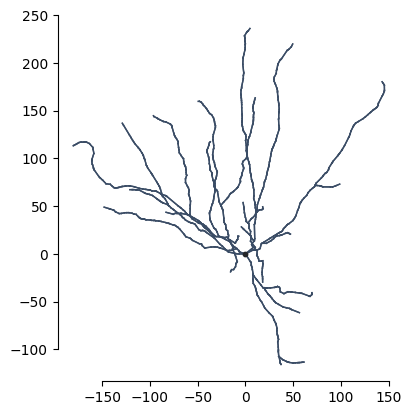

In [13]:
plot_neuron(neigh, feat)

#### Run inference

In [17]:
latents = np.zeros((dset.num_samples, config["model"]["dim"]))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None,]
#     lapl = compute_eig_lapl_torch_batch(adj, pos_enc_dim=config["model"]["pos_dim"]).float().cuda()
#     feat = torch.from_numpy(feat).float().cuda()[None,]

#     latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()

# run on CPU
for i in tqdm(range(dset.num_samples)):
    feat, neigh = dset.__getsingleitem__(i)
    adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cpu()[None,]
    lapl = compute_eig_lapl_torch_batch(adj, pos_enc_dim=config["model"]["pos_dim"]).float().cpu()
    feat = torch.from_numpy(feat).float().cpu()[None,]

    latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()

100%|██████████| 430/430 [01:50<00:00,  3.91it/s]


<ErrorbarContainer object of 3 artists>

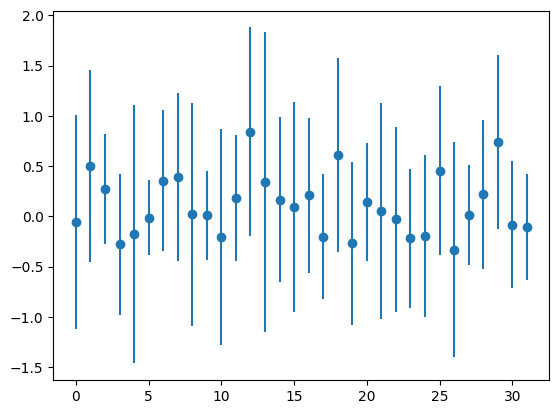

In [18]:
plt.scatter(np.arange(config["model"]["dim"]), latents.mean(axis=0))

plt.errorbar(
    np.arange(config["model"]["dim"]), latents.mean(axis=0), yerr=latents.std(axis=0), fmt="none"
)

In [20]:
colors = [list(sns.color_palette("mako", n_colors=10)[3])] + [
    list(sns.color_palette("mako", n_colors=10)[-2])
]

In [21]:
z = TSNE(n_components=2, perplexity=30).fit_transform(latents)

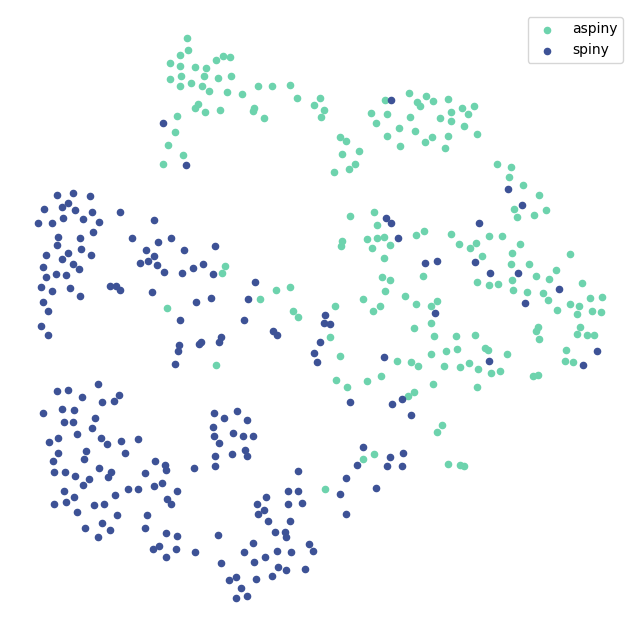

In [22]:
plot_tsne(
    z,
    np.concatenate([np.zeros(200, dtype=int), np.ones(230, dtype=int)]),
    targets=["aspiny", "spiny"],
    colors=[colors[1], colors[0]],
)

In [25]:
from umap import UMAP

z_umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.1).fit_transform(latents)

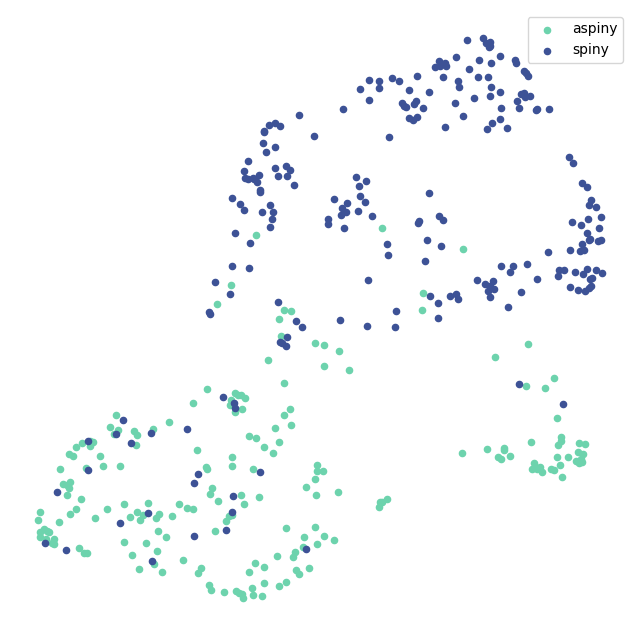

In [26]:
plot_tsne(
    z_umap,
    np.concatenate([np.zeros(200, dtype=int), np.ones(230, dtype=int)]),
    targets=["aspiny", "spiny"],
    colors=[colors[1], colors[0]],
)